## Classification using siamese model

In [2]:
import keras

In [3]:
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%matplotlib inline

In [4]:
from methods.baseline import Baseline

In [5]:
from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

## Configurações Globais

In [6]:
MAX_SEQUENCE_LENGTH_T = 100 # 40
MAX_SEQUENCE_LENGTH_D = 500 # 200
MAX_SEQUENCE_LENGTH_I = 738 # eclipse=1682, openoffice=738
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000

In [7]:
DOMAIN = 'openoffice'
DIR = 'data/processed/{}'.format(DOMAIN)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = 'baseline_classification_100epoch_10steps({})'.format(DOMAIN)
PRETRAINED_MODEL = 'modelos/model_baseline_100epochs_64batch({}).h5'.format(DOMAIN)

In [8]:
baseline = Baseline(DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D)

In [9]:
baseline.info_dict

{'bug_severity': 6,
 'bug_status': 3,
 'component': 144,
 'priority': 5,
 'product': 41,
 'version': 539}

In [ ]:
import keras
from keras.models import Model
from keras.layers import Input
from keras.models import load_model

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL, {'l2_normalize' : Baseline.l2_normalize, 
                                     'margin_loss' : Baseline.margin_loss,
                                    'pos_distance' : Baseline.pos_distance,
                                    'neg_distance' : Baseline.neg_distance,
                                    'stack_tensors': Baseline.stack_tensors})

#### Loading bug ids in memory

In [10]:
baseline.load_ids(DIR)

#### Generating tiple of batches

In [11]:
%%time

baseline.prepare_dataset()

Reading train data
Reading the test...



Reading test data
CPU times: user 269 ms, sys: 12.1 ms, total: 281 ms
Wall time: 270 ms


#### Loading train bugs

In [12]:
baseline.load_bugs()

## Siamese  model

In [13]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [14]:
from keras.layers import concatenate, Dropout, Add

bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

title_encoder = similarity_model.get_layer('FeatureLstmGenerationModel')
desc_encoder = similarity_model.get_layer('FeatureCNNGenerationModel')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder(bug_t_a)
bugt_d_a = desc_encoder(bug_d_a)
bugt_i_a = info_encoder(bug_i_a)
# Bug B
bugt_t_b = title_encoder(bug_t_b)
bugt_d_b = desc_encoder(bug_d_b)
bugt_i_b = info_encoder(bug_i_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    x = Dense(512)(x)
#     x = Dropout(0.5)(x)
    x = Activation('relu')(x)
    x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a, bug_t_b, bug_d_a, bug_d_b, bug_i_a, bug_i_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 738)          0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 500)          0                                            
__________________________________________________________________________________________________
info_b (InputLayer)             (None, 738)          0                                            
__________________________________________________________________________________________________
title_b (I

In [15]:
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

def batch_classification(train, dup_sets, batch_size, n_neg):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = baseline.batch_iterator(train, dup_sets, batch_size_normalized, n_neg)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title'], input_sample['title']])
    title_b = np.concatenate([input_pos['title'], input_neg['title']])
    desc_a = np.concatenate([input_sample['description'], input_sample['description']])
    desc_b = np.concatenate([input_pos['description'], input_neg['description']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    
    return title_a, title_b, desc_a, desc_b, info_a, info_b, sim

def batch_classification_siamese(train, dup_sets, batch_size, n_neg):
    while True:
        title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(train, dup_sets, batch_size, n_neg)
        
        yield ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [16]:
title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             512, 1)
test_validation = ({ 'title_a' : title_a, 'title_b': title_b, 
        'desc_a' : desc_a, 'desc_b' : desc_b, 'info_a' : info_a, 'info_b' : info_b }, sim)

In [17]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 1024, 1), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 

Epoch 1/100
10/10 [==============================] - 5s 511ms/step - loss: 0.6234 - acc: 0.7480 - val_loss: 0.3802 - val_acc: 0.8496
Epoch 2/100
10/10 [==============================] - 3s 339ms/step - loss: 0.4155 - acc: 0.8116 - val_loss: 0.4303 - val_acc: 0.8359
Epoch 3/100
10/10 [==============================] - 3s 320ms/step - loss: 0.3769 - acc: 0.8377 - val_loss: 0.3504 - val_acc: 0.8516
Epoch 4/100
10/10 [==============================] - 3s 315ms/step - loss: 0.3670 - acc: 0.8393 - val_loss: 0.2864 - val_acc: 0.8828
Epoch 5/100
10/10 [==============================] - 4s 356ms/step - loss: 0.3589 - acc: 0.8383 - val_loss: 0.2977 - val_acc: 0.8828
Epoch 6/100
10/10 [==============================] - 3s 343ms/step - loss: 0.3252 - acc: 0.8640 - val_loss: 0.2806 - val_acc: 0.8887
Epoch 7/100
10/10 [==============================] - 3s 348ms/step - loss: 0.3201 - acc: 0.8620 - val_loss: 0.2768 - val_acc: 0.8887
Epoch 8/100
10/10 [==============================] - 3s 327ms/step - 

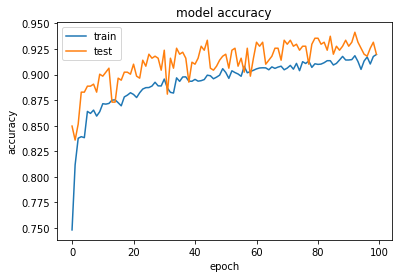

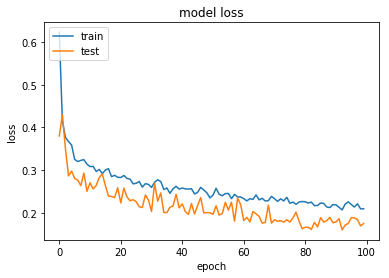

In [18]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

#### train

In [19]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
accuracy_score(y_true, y_scores)

0.90234375

#### test

In [20]:
from sklearn.metrics import accuracy_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
accuracy_score(y_true, y_scores)

0.90625

### Roc AUC/SCORE

#### train

In [21]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_auc_score(y_true, y_scores)

0.9659271240234375

#### test

In [22]:
from sklearn.metrics import roc_auc_score

title_a, title_b, desc_a, desc_b, info_a, info_b, sim = batch_classification(baseline.test_data, 
                                                                             baseline.dup_sets_test, 512, 1)

y_true = sim
y_scores = model_clf.predict([title_a, title_b, desc_a, desc_b, info_a, info_b])

roc_auc_score(y_true, y_scores)

0.9437255859375

#### Save the model

In [23]:
def save_model(model, name):
    m_dir = os.path.join('modelos')
    if not os.path.exists(m_dir):
        os.mkdir(m_dir)
    model.save(os.path.join(m_dir, "model_{}.h5".format(name)))
    print("Saved model to disk")

In [24]:
save_model(model_clf, SAVE_PATH)

Saved model to disk
